# Table of Contents

- [Imports, Settings and Common Things](#Settings)
- [Original & Efficient Zappa](#Original-Zappa)
- [Zappa Store](#ZappaStore)
    - [Projections and MH Rejections as a Function of Scale](#Projections-&-MH-Rejections-as-a-Function-of-Scale)
    - [Projections and MH Rejections as contour changes](#Projections,-MH-Rejections-as-contour-changes)
    - [MH Rejections and Curvature](#MH-Rejections-and-Curvature)
    - [Reprojections Failed](#Reprojections-Failed)
    - [Proj Rate & MH Rejection with Optimal Scaling as we get closer to the mode](#Projection-Rate-and-MH-Rejection-with-Optimal-Scaling)

## Settings

In [1]:
import sys
sys.path.append("..")
# Python Originals
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm as norm_distribution

# Manifold Sampling
from Zappa.zappa import zappa_sampling
from Zappa.ZappaStore import Zappa
from ManifoldHMCAlgorithms.mixture_manifoldhmc import MixtureManifoldHMC
from utils import logf_Jacobian, quick_MVN_scatter, quick_MVN_marginals
from utils import logp as logp_scale
from Manifolds.RotatedEllipse import RotatedEllipse
from HMC.gaussian_hmc import GaussianTargetHMC

# Target Distribution
Sigma = np.array([[1.0, 0.6], [0.6, 2.0]])
mu = np.zeros(2)                                 
target = multivariate_normal(mean=mu, cov=Sigma)

# Target distribution on the manifold & proposal on tangent
logf = lambda xy: logf_Jacobian(xy, Sigma)
logp = lambda xy: logp_scale(xy, sigma=s)

# Settings and starting point
s = 1
tol = 1.48e-08
a_guess = 1.0
maxiter = 50

np.random.seed(8)
x = target.rvs()
x0 = x
z = target.pdf(x)

# Original Zappa

This one should be used when you need speed. It simply returns the samples.

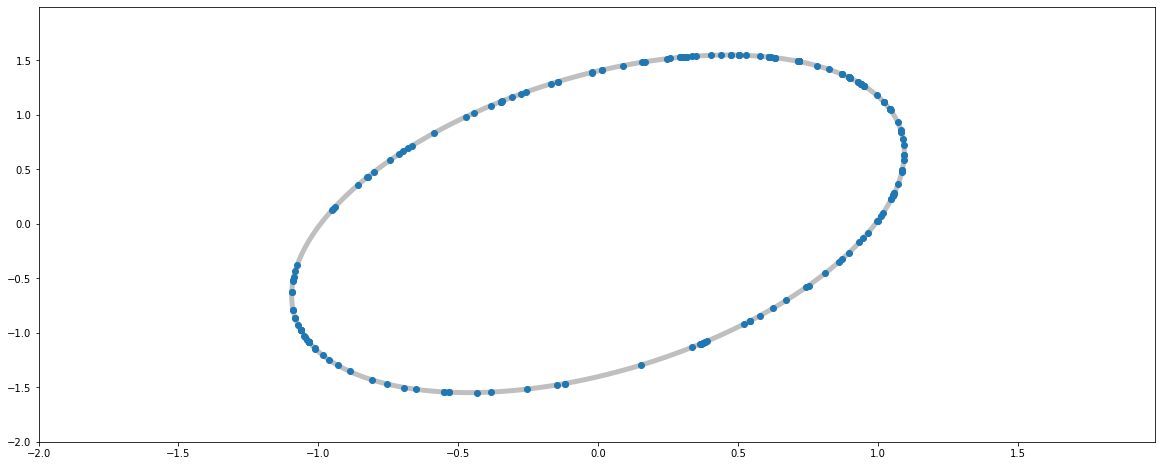

In [2]:
samples = zappa_sampling(x, RotatedEllipse(mu, Sigma, z), logf, logp, 200, s, tol, a_guess, maxiter)
quick_MVN_scatter(samples, target, levels=[z], alpha=0.5, zorder=-1, xlims=[-2, 2], ylims=[-2, 2])

# ZappaStore

Run Zappa algorithm and store all the variables. We can see that 

- the acceptance rate is about $50\%-70\%$
- MH Rejections happen about $5\%-10\%$ of the times
- When considering MH rejections when the first projections have succeded might be a bit more insightful, this is of course a slightly higher rejection rate.
- The rate of failed projections is still quite high at $30\%$.
- Failed reprojection rate (when MH succeded) is very low $0.05\%-0.5\%$ and might be attributable to numerical error.

In [3]:
manifold = RotatedEllipse(mu, Sigma, z)
ZappaObj = Zappa(x, manifold, logf, logp, 5000, s, tol, a_guess, maxiter)
out = ZappaObj.sample()
print("Acceptance Rate: ", ZappaObj.acceptance_rate() * 100)
print("MH Rejection Rate: ", ZappaObj.mh_rejection_rate() * 100)
print("MH Rejection Rate (Proj Successful): ", ZappaObj.mh_rejection_rate(over_proj_succeded=True) * 100)
print("Failed Projection Rate: ", ZappaObj.projection_failed_rate() * 100)
print("Failed Reproj Rate (MH Succeded): ", ZappaObj.reproj_failed_rate() * 100)

Acceptance Rate:  69.19999999999999
MH Rejection Rate:  7.5600000000000005
MH Rejection Rate (Proj Successful):  9.841187190835718
Failed Projection Rate:  23.18
Failed Reproj Rate (MH Succeded):  0.06490696668109044


## Projections & MH Rejections as a Function of Scale

As one would expect, as the scale gets larger:

- Projections failure happen more frequently because we overshoot and miss the manifold.
- The MH rejection rates increases because we are able to take larger steps which can lead us to regions of lower density. 
- Reprojection failures disappear because they are only due to numerical error in this example.
- As a result of the three facts above, total acceptance rate declines. 

In [4]:
scales = np.linspace(0.05, 10, num=20)
ZappaObjects = []
outs = []
ars = []   # Total Acceptance/Success rate
pfr = []   # Projection Failed Rate
mhr = []   # Metropolis.Hastings rejection rate
rfr = []   # Reprojection-Failed rate
for i in range(len(scales)):
    Z = Zappa(x, manifold, logf, logp, 5000, scales[i], tol, a_guess, maxiter)
    out = Z.sample()
    ZappaObjects.append(Z)
    outs.append(out)
    ars.append(Z.acceptance_rate())
    pfr.append(Z.projection_failed_rate())
    mhr.append(Z.mh_rejection_rate(True))    
    rfr.append(Z.reproj_failed_rate())

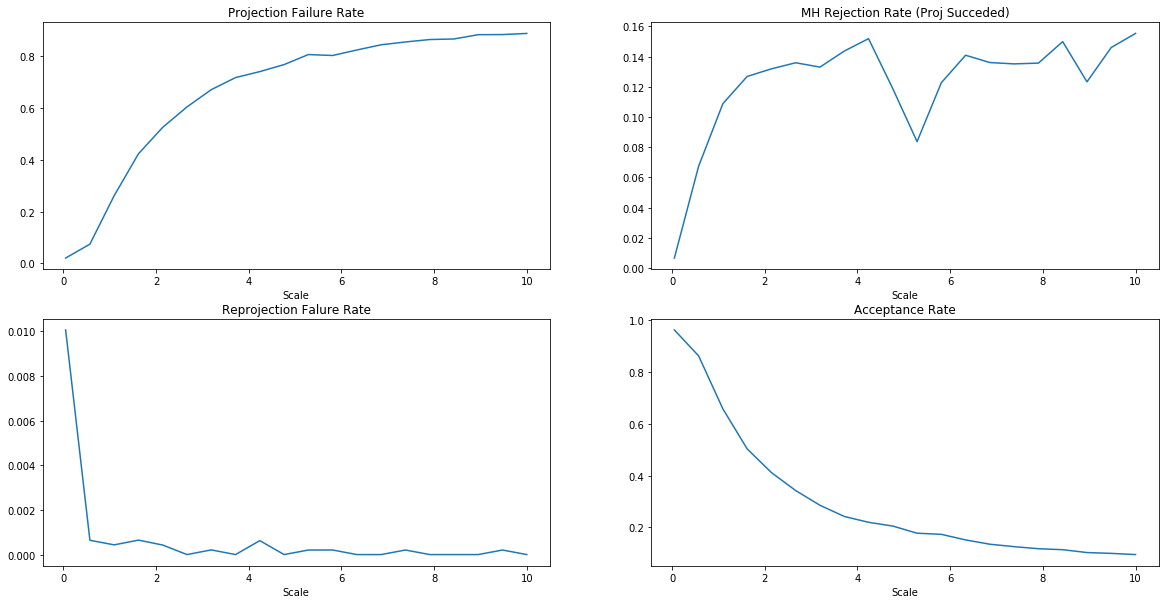

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax[0,0].plot(scales, pfr)
ax[0,0].set_title("Projection Failure Rate")
ax[0,0].set_xlabel("Scale")

ax[0,1].plot(scales, mhr)
ax[0,1].set_title("MH Rejection Rate (Proj Succeded)")
ax[0,1].set_xlabel("Scale")

ax[1,0].plot(scales, rfr)
ax[1,0].set_title("Reprojection Falure Rate")
ax[1,0].set_xlabel("Scale")

ax[1,1].plot(scales, ars)
ax[1,1].set_title("Acceptance Rate")
ax[1,1].set_xlabel("Scale")
plt.show()

## Projections, MH-Rejections as contour changes

Here the contours are changed linearly.

In [38]:
zs = np.linspace(-10, np.log(target.pdf(mu)-0.001), num=20)
ars = []   # Total Acceptance/Success rate
pfr = []   # Projection Failed Rate
mhr = []   # Metropolis.Hastings rejection rate
rfr = []   # Reprojection-Failed rate

for z in zs:
    manifold = RotatedEllipse(mu, Sigma, np.exp(z))
    Z = Zappa(x, manifold, logf, logp, 5000, s, tol, a_guess, maxiter)
    out = Z.sample()
    ars.append(Z.acceptance_rate())
    pfr.append(Z.projection_failed_rate())
    mhr.append(Z.mh_rejection_rate(True))    
    rfr.append(Z.reproj_failed_rate())

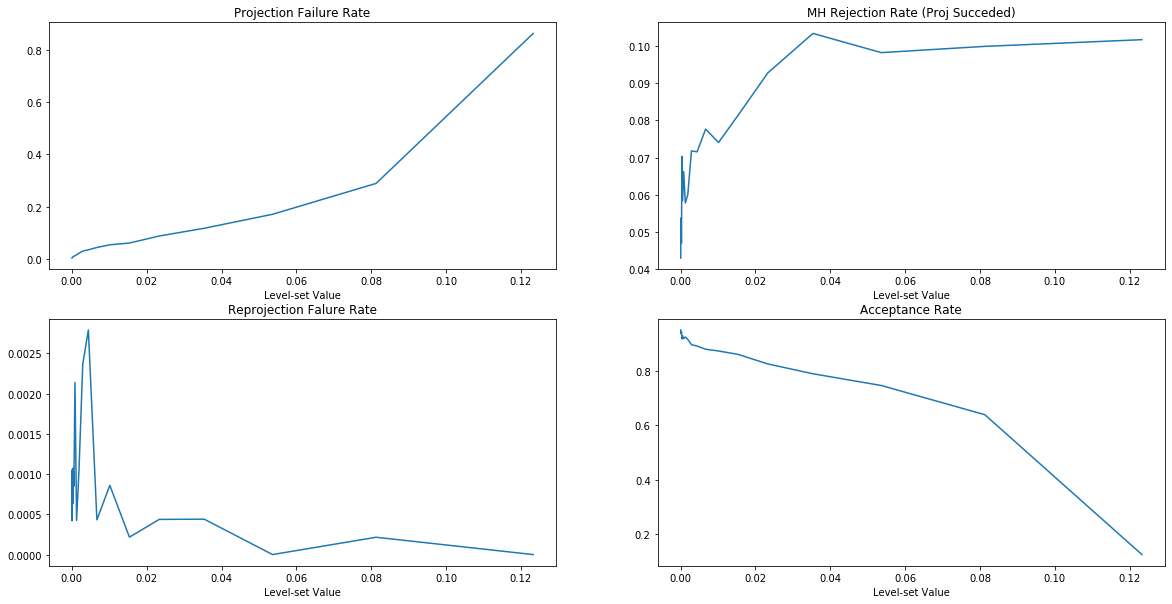

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax[0,0].plot(np.exp(zs), pfr)
ax[0,0].set_title("Projection Failure Rate")
ax[0,0].set_xlabel("Level-set Value")

ax[0,1].plot(np.exp(zs), mhr)
ax[0,1].set_title("MH Rejection Rate (Proj Succeded)")
ax[0,1].set_xlabel("Level-set Value")

ax[1,0].plot(np.exp(zs), rfr)
ax[1,0].set_title("Reprojection Falure Rate")
ax[1,0].set_xlabel("Level-set Value")

ax[1,1].plot(np.exp(zs), ars)
ax[1,1].set_title("Acceptance Rate")
ax[1,1].set_xlabel("Level-set Value")
plt.show()

Here the contours are changed exponentially

In [8]:
zs = np.linspace(0.01, target.pdf(mu)-0.001, num=20)
ars = []   # Total Acceptance/Success rate
pfr = []   # Projection Failed Rate
mhr = []   # Metropolis.Hastings rejection rate
rfr = []   # Reprojection-Failed rate

for z in zs:
    manifold = RotatedEllipse(mu, Sigma, z)
    Z = Zappa(x, manifold, logf, logp, 5000, s, tol, a_guess, maxiter)
    out = Z.sample()
    ars.append(Z.acceptance_rate())
    pfr.append(Z.projection_failed_rate())
    mhr.append(Z.mh_rejection_rate(True))    
    rfr.append(Z.reproj_failed_rate())

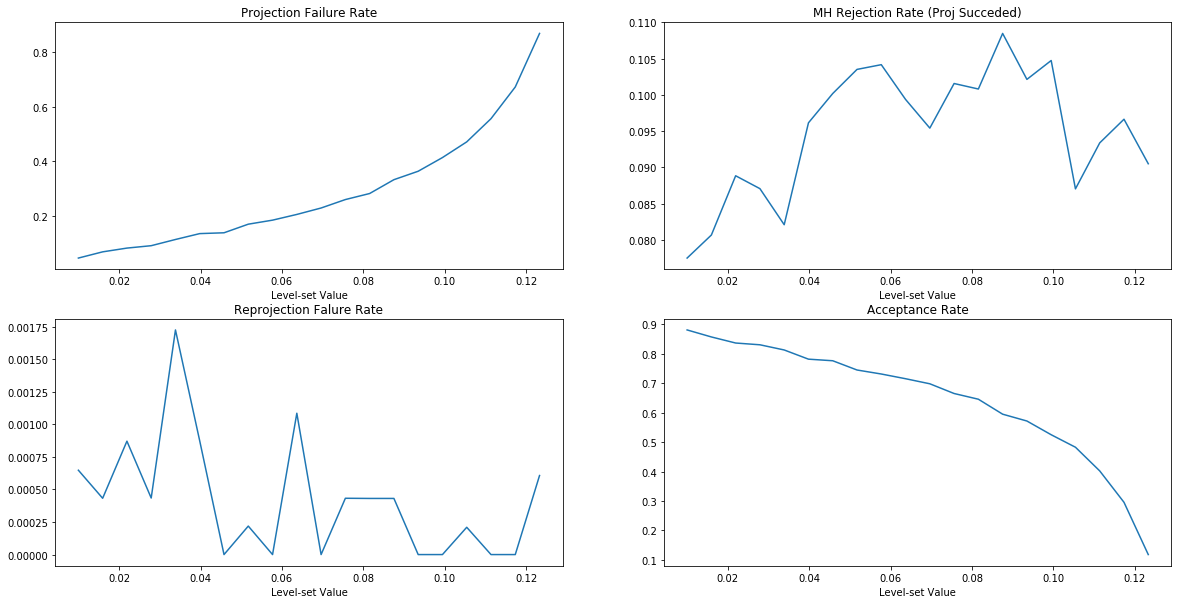

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax[0,0].plot(zs, pfr)
ax[0,0].set_title("Projection Failure Rate")
ax[0,0].set_xlabel("Level-set Value")

ax[0,1].plot(zs, mhr)
ax[0,1].set_title("MH Rejection Rate (Proj Succeded)")
ax[0,1].set_xlabel("Level-set Value")

ax[1,0].plot(zs, rfr)
ax[1,0].set_title("Reprojection Falure Rate")
ax[1,0].set_xlabel("Level-set Value")

ax[1,1].plot(zs, ars)
ax[1,1].set_title("Acceptance Rate")
ax[1,1].set_xlabel("Level-set Value")
plt.show()

### MH Rejections and Curvature

We can inspect if there is some pattern when it comes to rejection. Notice how mostly $x$ points from which we start, are in regions of highest curvature, while the $y$ points that are rejected are in region of lower curvature. This makes sense because:

- The gradient is smaller at the "tips" of the ellipse, meaning that $f(x) = \frac{1}{||\nabla \log \pi(x)||}$ is larger.
- The gradient is larger at the "sides" of the ellipse, meaning that $f(x)$ will be smaller.

As a result, when we are at a point $x$ on the "tips" and we suggest a point $y$ on the "sides" we are going from a point of higher density to a point of lower density, hence we have some probability of rejection.

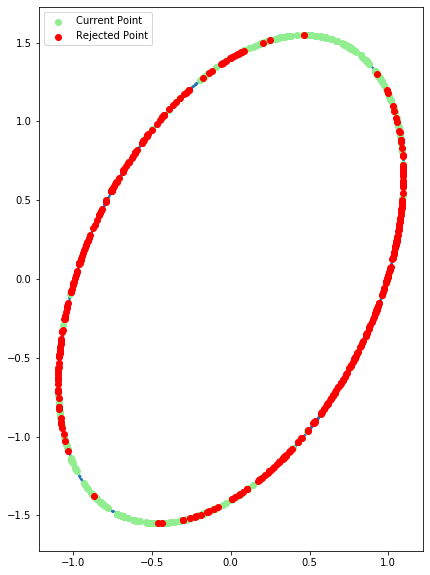

In [10]:
manifold = RotatedEllipse(mu, Sigma, target.pdf(x0))
ZappaObj = Zappa(x0, manifold, logf, logp, 5000, s, tol, a_guess, maxiter)
out = ZappaObj.sample()
events = out['events']
samples = out['samples']
vxs = out['vxs']
ys = out['ys']
mh_rej = events == "MHRejection"
fig, ax = plt.subplots(figsize=(10, 10))
# Scatter all the samples
ax.scatter(*samples.T, s=1)
# Scatter points at which the fail
ax.scatter(*samples[mh_rej].T, color="lightgreen", label="Current Point")
# Plot the new points y that have been rejected
ax.scatter(*ys[mh_rej].T, color="red", label="Rejected Point")
ax.set_aspect("equal")
plt.legend()
plt.show()

### Reprojections Failed

Let us also examine where the reprojections fail. Notice in the plot below how we seem to fail mainly due to numerical error.

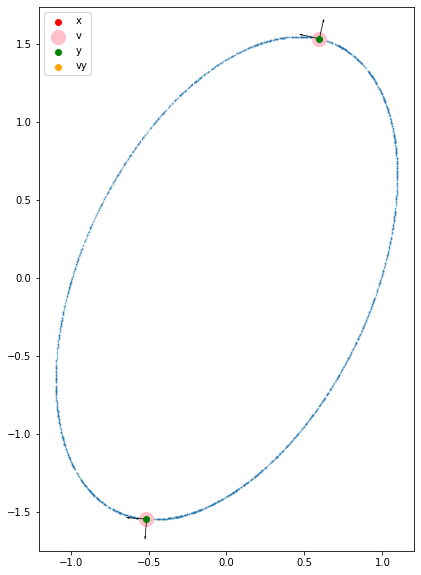

In [11]:
rpf = events == "ReprojFailed"
gxs = out['gxs']
txs = out['txs']
vys = out['vys']
fig, ax = plt.subplots(figsize=(10, 10))
# Scatter all the samples
ax.scatter(*samples.T, s=0.5, alpha=0.2)
# Scatter points at which the fail
ax.scatter(*samples[rpf].T, color="red", label="x")
# Scatter the proposed point along the tangent
ax.scatter(*(samples + vxs)[rpf].T, color="pink", label="v", s=200)
# Show the gradient there
ax.quiver(*samples[rpf].T, *gxs[rpf].T, width=0.002)
ax.quiver(*samples[rpf].T, *txs[rpf].T, width=0.002)
# Show y
ax.scatter(*ys[rpf].T, color="green", label="y")
# Show vy
ax.scatter(*(ys + vys)[rpf].T, color="orange", label="vy", zorder=-1)
#ax.set_xlim(0.7915, 0.7935)
#ax.set_xlim(0.79216, 0.792170)
#ax.set_ylim(1.4425, 1.444)
#ax.set_ylim(1.443578, 1.443582)
ax.set_aspect("equal")
plt.legend()
plt.show()

## Projection Rate and MH Rejection with Optimal Scaling

First, let's keep $s=0.5$ and target a contour that is very close to the mode. We can see that now the failed projection rate dominates, as one would expect. In addition also the MH-rejection rate is quite similar but possibly slightly larger as we are taking bigger steps. Overall the acceptance rate is very poor.

In [12]:
manifold2 = RotatedEllipse(mu, Sigma, target.pdf(mu)-0.0001)
x2 = manifold2.to_cartesian(np.random.uniform(0.0, 2*np.pi))
ZappaObj2 = Zappa(x2, manifold2, logf, logp, 5000, s, tol, a_guess, maxiter, 'root_jacobian')
out2 = ZappaObj2.sample()
print("Acceptance Rate: ", ZappaObj2.acceptance_rate() * 100)
print("MH Rejection Rate (Proj Successful): ", ZappaObj2.mh_rejection_rate(over_proj_succeded=True) * 100)
print("Failed Projection Rate: ", ZappaObj2.projection_failed_rate() * 100)
print("Failed Reproj Rate (MH Succeded): ", ZappaObj2.reproj_failed_rate() * 100)

Acceptance Rate:  3.56
MH Rejection Rate (Proj Successful):  12.31527093596059
Failed Projection Rate:  95.94
Failed Reproj Rate (MH Succeded):  0.0


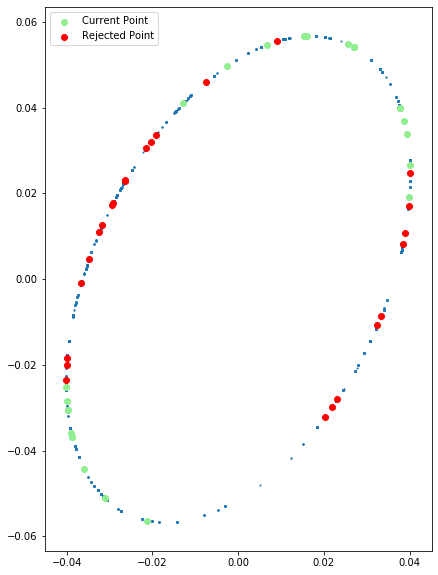

In [13]:
events2 = out2['events']
samples2 = out2['samples']
vxs2 = out2['vxs']
ys2 = out2['ys']
mh_rej2 = events2 == "MHRejection"
fig, ax = plt.subplots(figsize=(10, 10))
# Scatter all the samples
ax.scatter(*samples2.T, s=1)
# Scatter points at which the fail
ax.scatter(*samples2[mh_rej2].T, color="lightgreen", label="Current Point")
# Plot the new points y that have been rejected
ax.scatter(*ys2[mh_rej2].T, color="red", label="Rejected Point")
ax.set_aspect("equal")
plt.legend()
plt.show()

If we use the optimal scaling, instead, we find better results. Interestingly, we can see that now the failed reprojection rate is almost double. Again, this might be due to numerical error. We can also see that we have a much smaller failed reprojection rate, here about $5\%$ vs $30\%$. MH Rejection rate is also halved.

In [14]:
# Instantiate manifold
manifold3 = RotatedEllipse(mu, Sigma, target.pdf(mu)-0.00001)
# Find correct scaling
z_ok = target.pdf(x0)
peri_ok = RotatedEllipse(mu, Sigma, z_ok).peri()
scale = (0.5 * manifold3.peri() / peri_ok)
# Initial point on the manifold
x3 = manifold3.to_cartesian(np.random.uniform(0.0, 2*np.pi))
# Run Zappa with correct scaling
ZappaObj3 = Zappa(x3, manifold3, logf, logp, 5000, scale, tol, a_guess, maxiter, 'root_jacobian')
out3 = ZappaObj3.sample()
print("Acceptance Rate: ", ZappaObj3.acceptance_rate() * 100)
print("MH Rejection Rate (Proj Successful): ", ZappaObj3.mh_rejection_rate(over_proj_succeded=True) * 100)
print("Failed Projection Rate: ", ZappaObj3.projection_failed_rate() * 100)
print("Failed Reproj Rate (MH Succeded): ", ZappaObj3.reproj_failed_rate() * 100)

Acceptance Rate:  89.42
MH Rejection Rate (Proj Successful):  5.344317701732151
Failed Projection Rate:  5.319999999999999
Failed Reproj Rate (MH Succeded):  0.21065936380872127


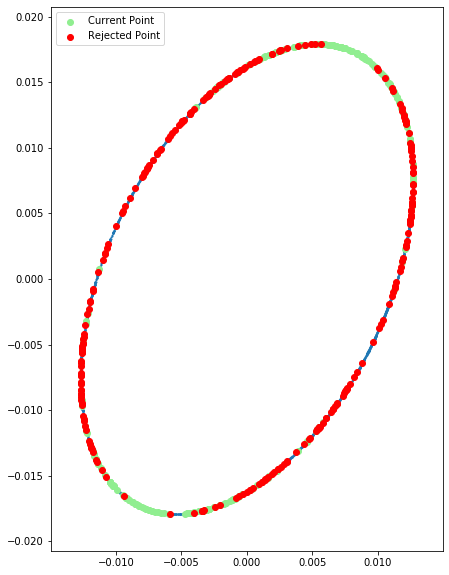

In [15]:
events3 = out3['events']
samples3 = out3['samples']
vxs3 = out3['vxs']
ys3 = out3['ys']
mh_rej3 = events3 == "MHRejection"
fig, ax = plt.subplots(figsize=(10, 10))
# Scatter all the samples
ax.scatter(*samples3.T, s=1)
# Scatter points at which the fail
ax.scatter(*samples3[mh_rej3].T, color="lightgreen", label="Current Point")
# Plot the new points y that have been rejected
ax.scatter(*ys3[mh_rej3].T, color="red", label="Rejected Point")
ax.set_aspect("equal")
plt.legend()
plt.show()

Let's see if there is a pattern when it comes to failed reprojections

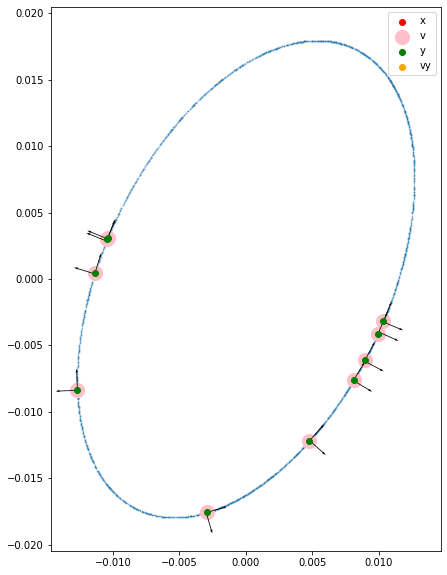

In [16]:
rpf3 = events3 == "ReprojFailed"
gxs3 = out3['gxs']
txs3 = out3['txs']
vys3 = out3['vys']
fig, ax = plt.subplots(figsize=(10, 10))
# Scatter all the samples
ax.scatter(*samples3.T, s=0.5, alpha=0.2)
# Scatter points at which the fail
ax.scatter(*samples3[rpf3].T, color="red", label="x")
# Scatter the proposed point along the tangent
ax.scatter(*(samples3 + vxs3)[rpf3].T, color="pink", label="v", s=200)
# Show the gradient there
ax.quiver(*samples3[rpf3].T, *gxs3[rpf3].T, width=0.002)
ax.quiver(*samples3[rpf3].T, *txs3[rpf3].T, width=0.002)
# Show y
ax.scatter(*ys3[rpf3].T, color="green", label="y")
# Show vy
ax.scatter(*(ys3 + vys3)[rpf3].T, color="orange", label="vy", zorder=-1)
ax.set_aspect("equal")
plt.legend()
plt.show()

Now let's change contour level but adaptive the scale and see if this leads to a different behavior in acceptance rate etc. We should see that we get a similar projection failure rate since we are adapting the step size.

In [17]:
zs = np.linspace(0.01, target.pdf(mu)-0.001, num=20)
ars = []   # Total Acceptance/Success rate
pfr = []   # Projection Failed Rate
mhr = []   # Metropolis.Hastings rejection rate
rfr = []   # Reprojection-Failed rate

for z in zs:
    # Instantiate manifold to sample
    manifold = RotatedEllipse(mu, Sigma, z)
    x = manifold.to_cartesian(np.random.uniform(0.0, 2*np.pi))
    # Find optimal scale
    z_ok = target.pdf(x0)
    peri_ok = RotatedEllipse(mu, Sigma, z_ok).peri()
    scale = (0.5 * manifold.peri() / peri_ok)
    # Sample the manifold using optimal scale
    Z = Zappa(x, manifold, logf, logp, 5000, scale, tol, a_guess, maxiter)
    out = Z.sample()
    ars.append(Z.acceptance_rate())
    pfr.append(Z.projection_failed_rate())
    mhr.append(Z.mh_rejection_rate(True))    
    rfr.append(Z.reproj_failed_rate())

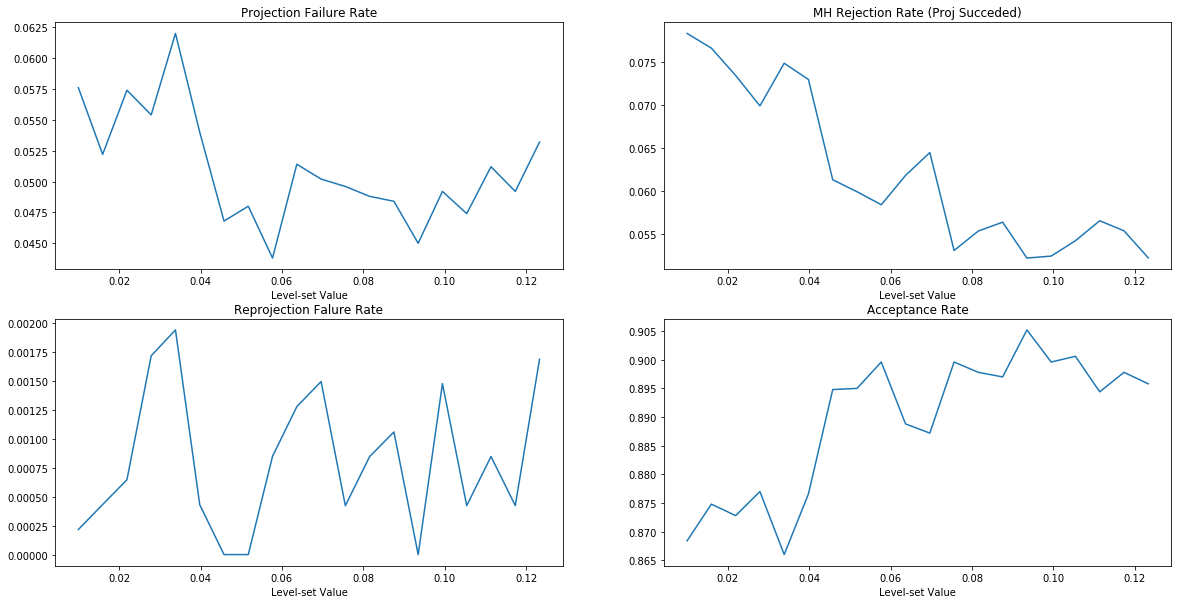

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax[0,0].plot(zs, pfr)
ax[0,0].set_title("Projection Failure Rate")
ax[0,0].set_xlabel("Level-set Value")

ax[0,1].plot(zs, mhr)
ax[0,1].set_title("MH Rejection Rate (Proj Succeded)")
ax[0,1].set_xlabel("Level-set Value")

ax[1,0].plot(zs, rfr)
ax[1,0].set_title("Reprojection Falure Rate")
ax[1,0].set_xlabel("Level-set Value")

ax[1,1].plot(zs, ars)
ax[1,1].set_title("Acceptance Rate")
ax[1,1].set_xlabel("Level-set Value")
plt.show()

In [36]:
zs = np.linspace(-10, np.log(target.pdf(mu)-0.001), num=20)
ars = []   # Total Acceptance/Success rate
pfr = []   # Projection Failed Rate
mhr = []   # Metropolis.Hastings rejection rate
rfr = []   # Reprojection-Failed rate

for z in zs:
    # Instantiate manifold to sample
    manifold = RotatedEllipse(mu, Sigma, np.exp(z))
    x = manifold.to_cartesian(np.random.uniform(0.0, 2*np.pi))
    # Find optimal scale
    z_ok = target.pdf(x0)
    peri_ok = RotatedEllipse(mu, Sigma, z_ok).peri()
    scale = (0.5 * manifold.peri() / peri_ok)
    # Sample the manifold using optimal scale
    Z = Zappa(x, manifold, logf, logp, 5000, scale, tol, a_guess, maxiter)
    out = Z.sample()
    ars.append(Z.acceptance_rate())
    pfr.append(Z.projection_failed_rate())
    mhr.append(Z.mh_rejection_rate(True))    
    rfr.append(Z.reproj_failed_rate())

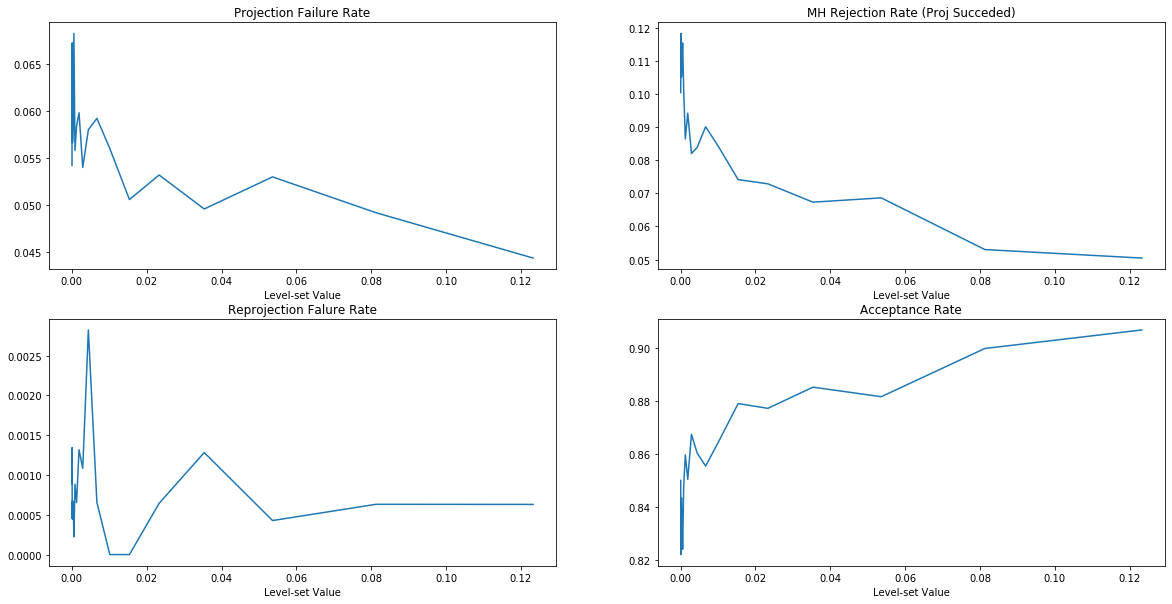

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax[0,0].plot(np.exp(zs), pfr)
ax[0,0].set_title("Projection Failure Rate")
ax[0,0].set_xlabel("Level-set Value")

ax[0,1].plot(np.exp(zs), mhr)
ax[0,1].set_title("MH Rejection Rate (Proj Succeded)")
ax[0,1].set_xlabel("Level-set Value")

ax[1,0].plot(np.exp(zs), rfr)
ax[1,0].set_title("Reprojection Falure Rate")
ax[1,0].set_xlabel("Level-set Value")

ax[1,1].plot(np.exp(zs), ars)
ax[1,1].set_title("Acceptance Rate")
ax[1,1].set_xlabel("Level-set Value")
plt.show()